# Imports and Functions

In [179]:
%matplotlib inline
import pickle
import csv
import os

import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

import autosklearn.regression
import shap

# Process Features

## ML pipeline outline

- standardize features
- impute nans, add nan_indicator column
- group k-fold splits
- auto-ml for 4 hours
    - in parallel run random forests
- shap interpretation for results

## Load data

In [424]:
path = "/home/tliu/lifesense/ls_data/jama_data/change_dfs"

phq_df = pd.read_pickle("{}/all_phq_corr_unit.df".format(path))
gad_spin_df = pd.read_pickle("{}/all_gad_spin_corr_unit.df".format(path))

rev_phq_df = pd.read_pickle("{}/all_rev_phq_corr_unit.df".format(path))
rev_gad_spin_df = pd.read_pickle("{}/all_rev_gad_spin_corr_unit.df".format(path))

In [80]:
demo_df = pd.read_pickle("ls_data/all_demo.df")

baseline_df = pd.read_excel("ls_data/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)
demo_df['gender'] = baseline_df['demo_gender']

In [81]:
demo_df['fam_income'] = demo_df['fam_income'].astype('category')
demo_df['ind_income'] = demo_df['ind_income'].astype('category')
demo_df['gender'] = demo_df['gender'].astype('category')
demo_df = pd.get_dummies(demo_df)
demo_df = demo_df.drop('study_id', axis='columns')
demo_df['pid'] = demo_df['pid'].astype(str)
demo_df['pid'] = demo_df['pid'].str.pad(width=8, side='left', fillchar='0')
demo_df.head()

,pid,age,marital_status_divorced,marital_status_domestic_partnership,marital_status_dont_know,marital_status_live_with_partner,marital_status_married,marital_status_pna,marital_status_separated,marital_status_single,...,ind_income_1,ind_income_2,ind_income_3,ind_income_4,ind_income_5,ind_income_6,ind_income_7,ind_income_99,gender_0,gender_1
0,91048552,28,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,31456993,33,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,51735262,27,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,69452375,25,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
4,28021601,58,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


# Feature Creation

In [556]:
demo_cols = list(demo_df.columns)
change_cols = list(phq_df.columns[phq_df.columns.str.endswith('change')])
#phq_include_cols = demo_cols + ['phq_diff'] + change_cols
#gad_spin_include_cols = demo_cols + ['gad_diff', 'spin_diff'] + change_cols

phq_include_cols = ['pid', 'phq_diff'] + change_cols
gad_spin_include_cols = ['pid', 'gad_diff', 'spin_diff'] + change_cols

In [557]:
phq_features = phq_df.merge(demo_df, on='pid', how='left')
gad_features = gad_spin_df.merge(demo_df, on='pid', how='left')

In [558]:
rev_phq_features = rev_phq_df.merge(demo_df, on='pid', how='left')
rev_gad_features = rev_gad_spin_df.merge(demo_df, on='pid', how='left')

In [559]:
phq_features = phq_features[~phq_features['phq_diff'].isna()]
gad_features = gad_features[(~gad_features['gad_diff'].isna()) | (~gad_features['spin_diff'].isna())]

In [560]:
rev_phq_features = rev_phq_features[~rev_phq_features['phq_diff'].isna()]
rev_gad_features = rev_gad_features[(~rev_gad_features['gad_diff'].isna()) | (~rev_gad_features['spin_diff'].isna())]

In [561]:
phq_features = phq_features[phq_include_cols]
gad_features = gad_features[gad_spin_include_cols]

In [562]:
rev_phq_features = rev_phq_features[phq_include_cols]
rev_gad_features = rev_gad_features[gad_spin_include_cols]

In [563]:
def build_nan_features(comm_features, fill_val=0, dedup_nan=False):
    """Adds additional feature columns for nans and fills NaNs with fill_val.
    features created:
    - {col}_nan_indicator: one-hot column indicating whether 
    """
    comm_indicator = comm_features.isnull().astype(int).add_suffix("_nan_indicator")
    # keep indicator cols that correspond to cols with NaNs
    comm_indicator = comm_indicator.loc[:, (comm_indicator.sum(axis=0) > 0)]

    indicator_cols = comm_indicator.columns
    comm_features[indicator_cols] = comm_indicator[indicator_cols]

    if fill_val == 'mean':
        print('filling mean')
        fill_val = comm_features.mean()
    elif fill_val == 'median':
        print('filling median')
        fill_val = comm_features.median()
    
    comm_features = comm_features.fillna(fill_val)

    if dedup_nan:
        ind_cols = [x for x in comm_features.columns if 'indicator' in x]
        ind_df = comm_features[ind_cols]

        keep_df = ind_df.T.drop_duplicates().T
        keep_cols = list(keep_df.columns.values)
        drop_ind_cols = list(set(ind_cols) - set(keep_cols))

        comm_features = comm_features.drop(drop_ind_cols, axis='columns')

    return comm_features

In [564]:
phq_features = build_nan_features(phq_features, fill_val="median", dedup_nan=True)
gad_features = build_nan_features(gad_features, fill_val="median", dedup_nan=True)

filling median
filling median


In [565]:
rev_phq_features = build_nan_features(rev_phq_features, fill_val="median", dedup_nan=True)
rev_gad_features = build_nan_features(rev_gad_features, fill_val="median", dedup_nan=True)

filling median
filling median


In [566]:
phq_features.shape

(1360, 23)

In [567]:
gad_features.shape

(1033, 25)

In [568]:
rev_phq_features.shape

(1360, 23)

In [569]:
rev_gad_features.shape

(1033, 25)

## Train/Test splits

In [570]:
test_pids = pickle.load(open("{}/test_pids.lst".format(path), "rb"))
train_pids = pickle.load(open("{}/train_pids.lst".format(path), "rb"))

### Forward change

In [571]:
# PHQ
train_data = phq_features.loc[phq_features['pid'].isin(train_pids)]
test_data = phq_features.loc[phq_features['pid'].isin(test_pids)]

#train_data = train_data.drop('pid', axis='columns')
#test_data = test_data.drop('pid', axis='columns')

X_train_phq = train_data.drop('phq_diff', axis='columns')
y_train_phq = train_data['phq_diff']

X_test_phq = test_data.drop('phq_diff', axis='columns')
y_test_phq = test_data['phq_diff']

train_data.to_pickle("features/phq_train_data.df")
test_data.to_pickle("features/phq_test_data.df")

In [572]:
# gad
train_data = gad_features.loc[gad_features['pid'].isin(train_pids)]
test_data = gad_features.loc[gad_features['pid'].isin(test_pids)]

#train_data = train_data.drop('pid', axis='columns')
#test_data = test_data.drop('pid', axis='columns')

X_train_gad = train_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_train_gad = train_data['gad_diff']

X_test_gad = test_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_test_gad = test_data['gad_diff']

train_data.to_pickle("features/gad_train_data.df")
test_data.to_pickle("features/gad_test_data.df")

In [573]:
# spin
train_data = gad_features.loc[gad_features['pid'].isin(train_pids)]
test_data = gad_features.loc[gad_features['pid'].isin(test_pids)]

#train_data = train_data.drop('pid', axis='columns')
#test_data = test_data.drop('pid', axis='columns')

X_train_spin = train_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_train_spin = train_data['spin_diff']

X_test_spin = test_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_test_spin = test_data['spin_diff']

train_data.to_pickle("features/spin_train_data.df")
test_data.to_pickle("features/spin_test_data.df")

### Reverse change

In [574]:
# PHQ
rev_train_data = rev_phq_features.loc[rev_phq_features['pid'].isin(train_pids)]
rev_test_data = rev_phq_features.loc[rev_phq_features['pid'].isin(test_pids)]

#rev_train_data = rev_train_data.drop('pid', axis='columns')
#rev_test_data = rev_test_data.drop('pid', axis='columns')

X_rev_train_phq = rev_train_data.drop('phq_diff', axis='columns')
y_rev_train_phq = rev_train_data['phq_diff']

X_rev_test_phq = rev_test_data.drop('phq_diff', axis='columns')
y_rev_test_phq = rev_test_data['phq_diff']

rev_train_data.to_pickle("features/rev_phq_rev_train_data.df")
rev_test_data.to_pickle("features/rev_phq_rev_test_data.df")

In [575]:
# gad
rev_train_data = rev_gad_features.loc[rev_gad_features['pid'].isin(train_pids)]
rev_test_data = rev_gad_features.loc[rev_gad_features['pid'].isin(test_pids)]

#rev_train_data = rev_train_data.drop('pid', axis='columns')
#rev_test_data = rev_test_data.drop('pid', axis='columns')

X_rev_train_gad = rev_train_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_rev_train_gad = rev_train_data['gad_diff']

X_rev_test_gad = rev_test_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_rev_test_gad = rev_test_data['gad_diff']

rev_train_data.to_pickle("features/rev_gad_rev_train_data.df")
rev_test_data.to_pickle("features/rev_gad_rev_test_data.df")

In [576]:
# spin
rev_train_data = rev_gad_features.loc[rev_gad_features['pid'].isin(train_pids)]
rev_test_data = rev_gad_features.loc[rev_gad_features['pid'].isin(test_pids)]

#rev_train_data = rev_train_data.drop('pid', axis='columns')
#rev_test_data = rev_test_data.drop('pid', axis='columns')

X_rev_train_spin = rev_train_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_rev_train_spin = rev_train_data['spin_diff']

X_rev_test_spin = rev_test_data.drop(['gad_diff', 'spin_diff'], axis='columns')
y_rev_test_spin = rev_test_data['spin_diff']

rev_train_data.to_pickle("features/rev_spin_rev_train_data.df")
rev_test_data.to_pickle("features/rev_spin_rev_test_data.df")

# Predicting PHQ changes

In [577]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.externals import joblib

In [578]:
phq_groups = X_train_phq.pop('pid')
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X_train_phq, y_train_phq, phq_groups)

5

## Classification

In [579]:
scaler = StandardScaler()
#X_train_phq = scaler.fit_transform(X_train_phq)
#X_test_phq_scale = scaler.fit_transform(X_test_phq.drop('pid', axis='columns'))

In [580]:
search_params

{'bootstrap': [True, False],
 'criterion': ['mse', 'mae'],
 'max_depth': [None, 10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

### Random search to find reasonable ranges

In [581]:
def class_labels(x):
    if x > 0: return 1
    if x < 0: return -1
    return 0

y_train_phq_class = y_train_phq.apply(class_labels)
y_test_phq_class = y_test_phq.apply(class_labels)

In [582]:
y_train_phq_class.value_counts()

-1    403
 1    400
 0    222
Name: phq_diff, dtype: int64

In [583]:
rf = RandomForestClassifier()

random_search_params = dict(
    bootstrap=[True, False],
    max_depth=[None] + [x for x in range(1, 11, 1)],
    max_features=['auto', 'sqrt'],
    min_samples_leaf=[x for x in range(1, 5)],
    min_samples_split=[x for x in range(2, 11, 2)],
    n_estimators=[x for x in range(100, 1001, 100)]
)

f1_scorer = make_scorer(f1_score, average='micro')

phq_clf = RandomizedSearchCV(rf, 
                             random_search_params, 
                             cv=group_kfold.split(X_train_phq, y_train_phq_class, phq_groups),
                             n_iter=100,
                             random_state=2,
                             verbose=True, 
                             n_jobs=10,
                             scoring=f1_scorer)
phq_clf_random_search = phq_clf.fit(X_train_phq, y_train_phq_class)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   22.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   45.3s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   54.4s finished


In [584]:
phq_clf_random_search.best_score_

0.4195121951219512

In [585]:
phq_clf_random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 2,
 'bootstrap': True}

In [586]:
from sklearn.metrics import accuracy_score, f1_score
train_preds_phq_class = phq_clf_random_search.predict(X_train_phq)
print(accuracy_score(y_true=y_train_phq_class, y_pred=train_preds_phq_class))
print(f1_score(y_true=y_train_phq_class, y_pred=train_preds_phq_class, average='weighted'))

0.4848780487804878
0.42536195526018783


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [587]:
y_train_phq_class.shape

(1025,)

In [588]:
best_phq_clf = phq_clf_random_search.best_estimator_
joblib.dump(best_phq_clf, "models/best_phq_clf.pkl")

['models/best_phq_clf.pkl']

In [589]:
maj_pred = [-1] * y_train_phq_class.shape[0]
print("majority baseline train acc: {}".format(accuracy_score(y_true=y_train_phq_class, y_pred=maj_pred)))
print("majority baseline train weighted F1: {}".format(f1_score(y_true=y_train_phq_class, y_pred=maj_pred, average='weighted')))

majority baseline train acc: 0.3931707317073171
majority baseline train weighted F1: 0.22191569310651094


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [592]:
test_preds_phq_class = best_phq_clf.predict(X_test_phq.drop('pid', axis='columns'))
print("RF test acc: {}".format(accuracy_score(y_true=y_test_phq_class, y_pred=test_preds_phq_class)))
print("RF test weighted F1: {}".format(f1_score(y_true=y_test_phq_class, y_pred=test_preds_phq_class, average='weighted')))
#print(roc_auc_score(y_true=y_test_phq_class, y_score=test_scores_phq_class, average='weighted', multi_class='ovr'))

RF test acc: 0.37910447761194027
RF test weighted F1: 0.3227868947787068


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [593]:
maj_pred = [-1] * y_test_phq_class.shape[0]
print("majority baseline test acc: {}".format(accuracy_score(y_true=y_test_phq_class, y_pred=maj_pred)))
print("majority baseline test weighted f1: {}".format(f1_score(y_true=y_test_phq_class, y_pred=maj_pred, average='weighted')))

majority baseline test acc: 0.3402985074626866
majority baseline test weighted f1: 0.17280191470265602


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SHAP Feature Importance

In [594]:
explainer = shap.TreeExplainer(best_phq_clf)

### Test Data

In [595]:
shap_values = explainer.shap_values(X_test_phq.drop('pid', axis='columns'))

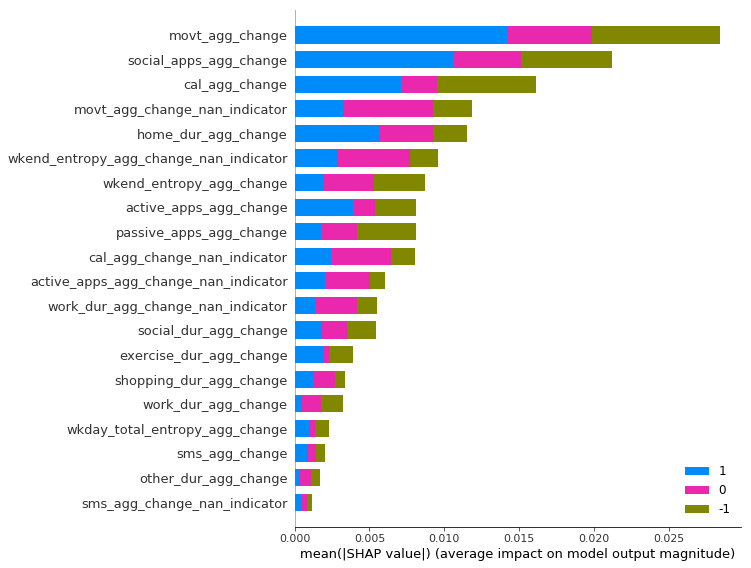

In [612]:
shap.summary_plot(shap_values, X_test_phq.drop('pid', axis='columns'), class_names=[-1,0,1])

In [688]:
shap.initjs()

### SHAP for decreases (-1)
- higher values means the model is more likely to predict -1

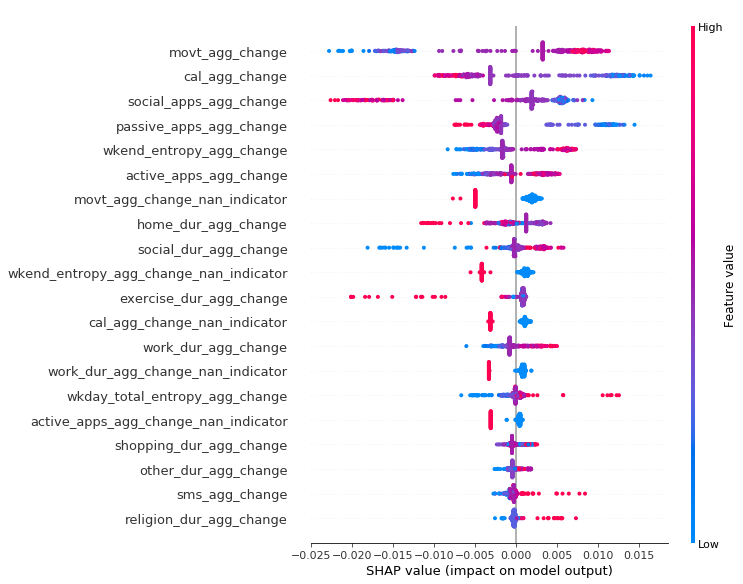

In [597]:
shap.summary_plot(shap_values[0], X_test_phq.drop('pid', axis='columns'))

In [693]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_phq.drop('pid', axis='columns'))

### SHAP for no change (0)
- higher values means the model is more likely to predict 0

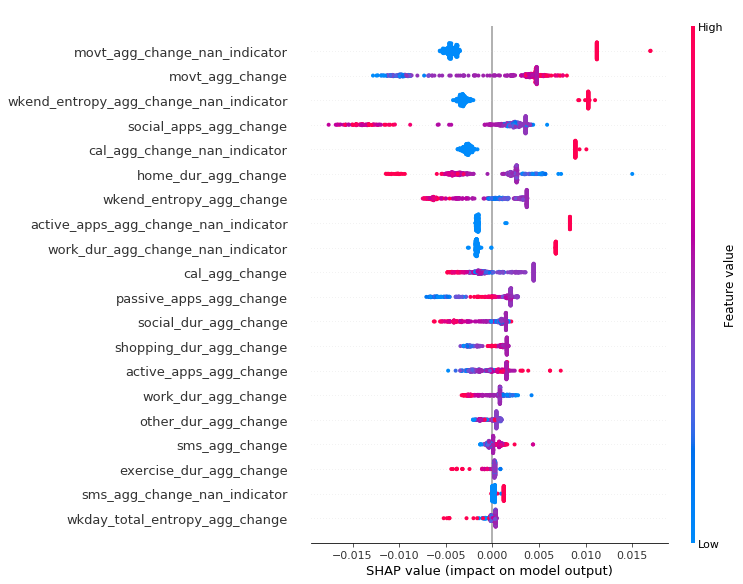

In [598]:
shap.summary_plot(shap_values[1], X_test_phq.drop('pid', axis='columns'))

### SHAP for increases (+1)
- higher output values means the model is more likely to predict 1

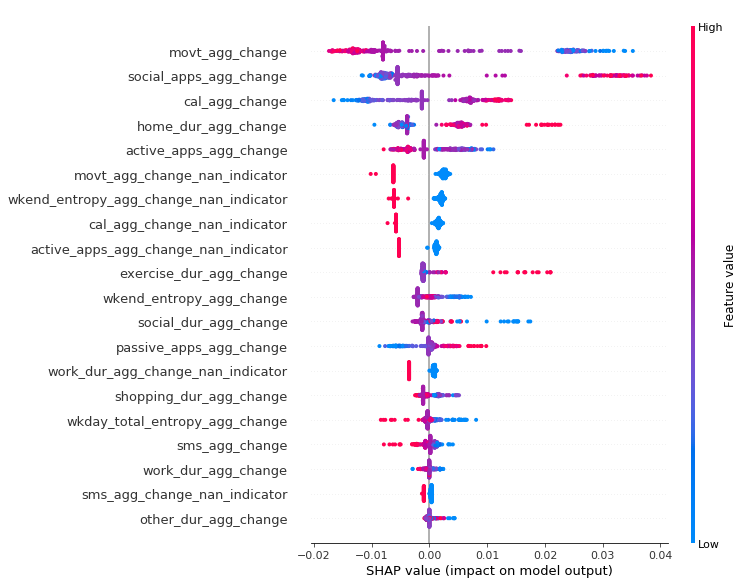

In [599]:
shap.summary_plot(shap_values[2], X_test_phq.drop('pid', axis='columns'))

# Predicting PHQ Changes (reversed)

In [600]:
def class_labels(x):
    if x > 0: return 1
    if x < 0: return -1
    return 0

y_rev_train_phq_class = y_rev_train_phq.apply(class_labels)
y_rev_test_phq_class = y_rev_test_phq.apply(class_labels)

In [601]:
y_rev_train_phq_class.value_counts()

-1    403
 1    400
 0    222
Name: phq_diff, dtype: int64

In [602]:
rev_phq_groups = X_rev_train_phq.pop('pid')
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X_rev_train_phq, y_rev_train_phq, rev_phq_groups)

5

In [603]:
rf = RandomForestClassifier()

random_search_params = dict(
    bootstrap=[True, False],
    max_depth=[None] + [x for x in range(1, 11, 1)],
    max_features=['auto', 'sqrt'],
    min_samples_leaf=[x for x in range(1, 5)],
    min_samples_split=[x for x in range(2, 11, 2)],
    n_estimators=[x for x in range(100, 1001, 100)]
)

f1_scorer = make_scorer(f1_score, average='micro')

rev_phq_clf = RandomizedSearchCV(rf, 
                             random_search_params, 
                             cv=group_kfold.split(X_rev_train_phq, y_rev_train_phq_class, rev_phq_groups),
                             n_iter=100,
                             random_state=2,
                             verbose=True, 
                             n_jobs=10,
                             scoring=f1_scorer)
rev_phq_clf_random_search = rev_phq_clf.fit(X_rev_train_phq, y_rev_train_phq_class)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.8s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   21.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   44.1s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   53.1s finished


In [604]:
rev_phq_clf_random_search.best_score_

0.3804878048780488

In [605]:
rev_phq_clf_random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 1,
 'bootstrap': False}

In [606]:
from sklearn.metrics import accuracy_score, f1_score
rev_train_preds_phq_class = rev_phq_clf_random_search.predict(X_rev_train_phq)
print(accuracy_score(y_true=y_rev_train_phq_class, y_pred=rev_train_preds_phq_class))
print(f1_score(y_true=y_rev_train_phq_class, y_pred=rev_train_preds_phq_class, average='weighted'))

0.42341463414634145
0.36125810255725044


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [607]:
y_rev_train_phq_class.shape

(1025,)

In [608]:
best_rev_phq_clf = rev_phq_clf_random_search.best_estimator_
joblib.dump(best_rev_phq_clf, "models/best_rev_phq_clf.pkl")

['models/best_rev_phq_clf.pkl']

In [609]:
maj_pred = [-1] * y_rev_train_phq_class.shape[0]
print("majority baseline rev_train acc: {}".format(accuracy_score(y_true=y_rev_train_phq_class, y_pred=maj_pred)))
print("majority baseline rev_train weighted F1: {}".format(f1_score(y_true=y_rev_train_phq_class, y_pred=maj_pred, average='weighted')))

majority baseline rev_train acc: 0.3931707317073171
majority baseline rev_train weighted F1: 0.22191569310651094


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [610]:
rev_test_preds_phq_class = best_rev_phq_clf.predict(X_rev_test_phq.drop('pid', axis='columns'))
print("RF rev_test acc: {}".format(accuracy_score(y_true=y_rev_test_phq_class, y_pred=rev_test_preds_phq_class)))
print("RF rev_test weighted F1: {}".format(f1_score(y_true=y_rev_test_phq_class, y_pred=rev_test_preds_phq_class, average='weighted')))
#print(roc_auc_score(y_true=y_rev_test_phq_class, y_score=rev_test_scores_phq_class, average='weighted', multi_class='ovr'))

RF rev_test acc: 0.3761194029850746
RF rev_test weighted F1: 0.30891426309709547


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [611]:
maj_pred = [-1] * y_rev_test_phq_class.shape[0]
print("majority baseline rev_test acc: {}".format(accuracy_score(y_true=y_rev_test_phq_class, y_pred=maj_pred)))
print("majority baseline rev_test weighted f1: {}".format(f1_score(y_true=y_rev_test_phq_class, y_pred=maj_pred, average='weighted')))

majority baseline rev_test acc: 0.3402985074626866
majority baseline rev_test weighted f1: 0.17280191470265602


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SHAP Feature Importance

In [613]:
explainer = shap.TreeExplainer(best_rev_phq_clf)

### Test Data

In [614]:
shap_values = explainer.shap_values(X_test_phq.drop('pid', axis='columns'))

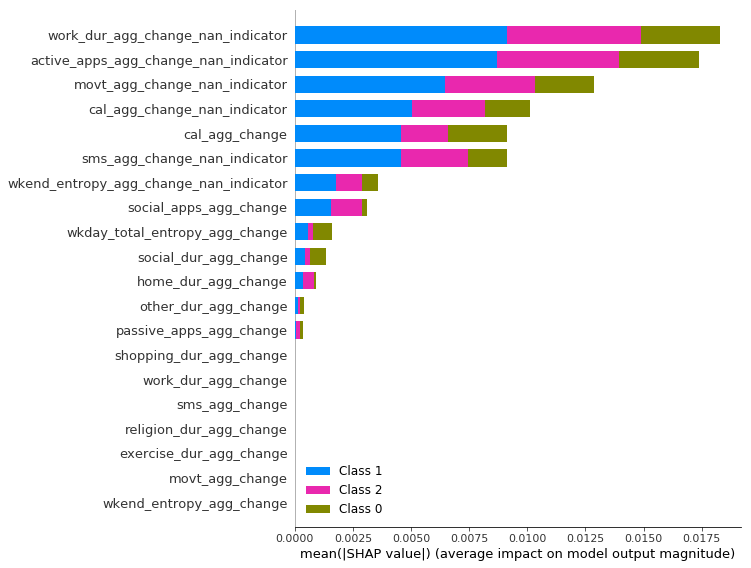

In [615]:
shap.summary_plot(shap_values, X_test_phq.drop('pid', axis='columns'))

# Predicting GAD Changes

In [616]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.externals import joblib

In [617]:
gad_groups = X_train_gad.pop('pid')
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X_train_gad, y_train_gad, gad_groups)

5

## Classification

In [618]:
scaler = StandardScaler()
#X_train_gad = scaler.fit_transform(X_train_gad)
#X_test_gad_scale = scaler.fit_transform(X_test_gad.drop('pid', axis='columns'))

In [619]:
search_params

{'bootstrap': [True, False],
 'criterion': ['mse', 'mae'],
 'max_depth': [None, 10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

### Random search to find reasonable ranges

In [620]:
def class_labels(x):
    if x > 0: return 1
    if x < 0: return -1
    return 0

y_train_gad_class = y_train_gad.apply(class_labels)
y_test_gad_class = y_test_gad.apply(class_labels)

In [621]:
y_train_gad_class.value_counts()

 1    313
-1    309
 0    154
Name: gad_diff, dtype: int64

In [622]:
rf = RandomForestClassifier()

random_search_params = dict(
    bootstrap=[True, False],
    max_depth=[None] + [x for x in range(1, 11, 1)],
    max_features=['auto', 'sqrt'],
    min_samples_leaf=[x for x in range(1, 5)],
    min_samples_split=[x for x in range(2, 11, 2)],
    n_estimators=[x for x in range(100, 1001, 100)]
)

f1_scorer = make_scorer(f1_score, average='micro')

gad_clf = RandomizedSearchCV(rf, 
                             random_search_params, 
                             cv=group_kfold.split(X_train_gad, y_train_gad_class, gad_groups),
                             n_iter=100,
                             random_state=2,
                             verbose=True, 
                             n_jobs=10,
                             scoring=f1_scorer)
gad_clf_random_search = gad_clf.fit(X_train_gad, y_train_gad_class)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   41.7s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   49.9s finished


In [623]:
gad_clf_random_search.best_score_

0.43170103092783507

In [624]:
gad_clf_random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 2,
 'bootstrap': False}

In [625]:
from sklearn.metrics import accuracy_score, f1_score
train_preds_gad_class = gad_clf_random_search.predict(X_train_gad)
print(accuracy_score(y_true=y_train_gad_class, y_pred=train_preds_gad_class))
print(f1_score(y_true=y_train_gad_class, y_pred=train_preds_gad_class, average='weighted'))

0.5193298969072165
0.45526278566633005


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [626]:
y_train_gad_class.shape

(776,)

In [627]:
best_gad_clf = gad_clf_random_search.best_estimator_
joblib.dump(best_gad_clf, "models/best_gad_clf.pkl")

['models/best_gad_clf.pkl']

In [628]:
maj_pred = [-1] * y_train_gad_class.shape[0]
print("majority baseline train acc: {}".format(accuracy_score(y_true=y_train_gad_class, y_pred=maj_pred)))
print("majority baseline train weighted F1: {}".format(f1_score(y_true=y_train_gad_class, y_pred=maj_pred, average='weighted')))

majority baseline train acc: 0.39819587628865977
majority baseline train weighted F1: 0.22680649912109843


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [629]:
test_preds_gad_class = best_gad_clf.predict(X_test_gad.drop('pid', axis='columns'))
print("RF test acc: {}".format(accuracy_score(y_true=y_test_gad_class, y_pred=test_preds_gad_class)))
print("RF test weighted F1: {}".format(f1_score(y_true=y_test_gad_class, y_pred=test_preds_gad_class, average='weighted')))
#print(roc_auc_score(y_true=y_test_gad_class, y_score=test_scores_gad_class, average='weighted', multi_class='ovr'))

RF test acc: 0.4163424124513619
RF test weighted F1: 0.35915343073433265


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [630]:
maj_pred = [-1] * y_test_gad_class.shape[0]
print("majority baseline test acc: {}".format(accuracy_score(y_true=y_test_gad_class, y_pred=maj_pred)))
print("majority baseline test weighted f1: {}".format(f1_score(y_true=y_test_gad_class, y_pred=maj_pred, average='weighted')))

majority baseline test acc: 0.4163424124513619
majority baseline test weighted f1: 0.24477273699063584


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SHAP Feature Importance

In [631]:
explainer = shap.TreeExplainer(best_gad_clf)

### Test Data

In [632]:
shap_values = explainer.shap_values(X_test_gad.drop('pid', axis='columns'))

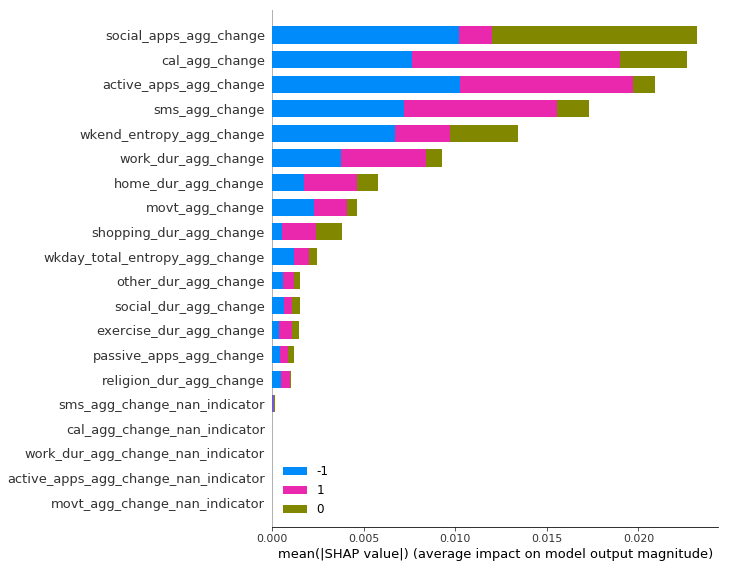

In [633]:
shap.summary_plot(shap_values, X_test_gad.drop('pid', axis='columns'), class_names=[-1,0,1])

### SHAP for decreases (-1)
- higher values means the model is more likely to predict -1

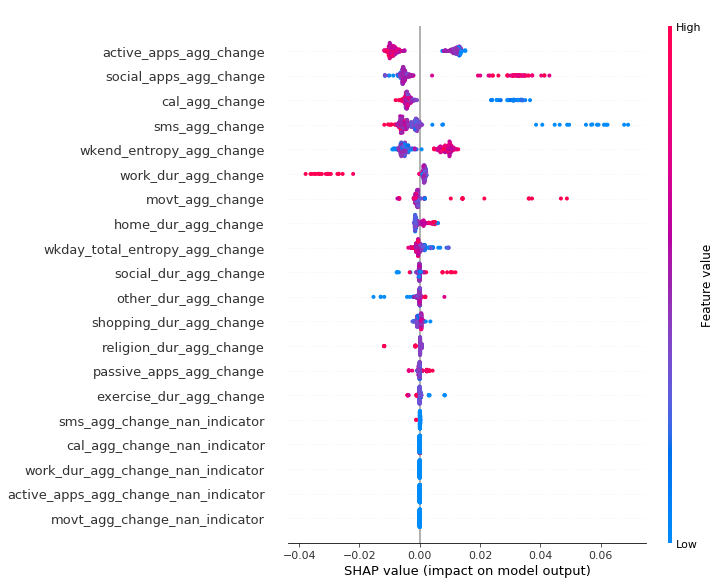

In [634]:
shap.summary_plot(shap_values[0], X_test_gad.drop('pid', axis='columns'))

### SHAP for no change (0)
- higher values means the model is more likely to predict 0

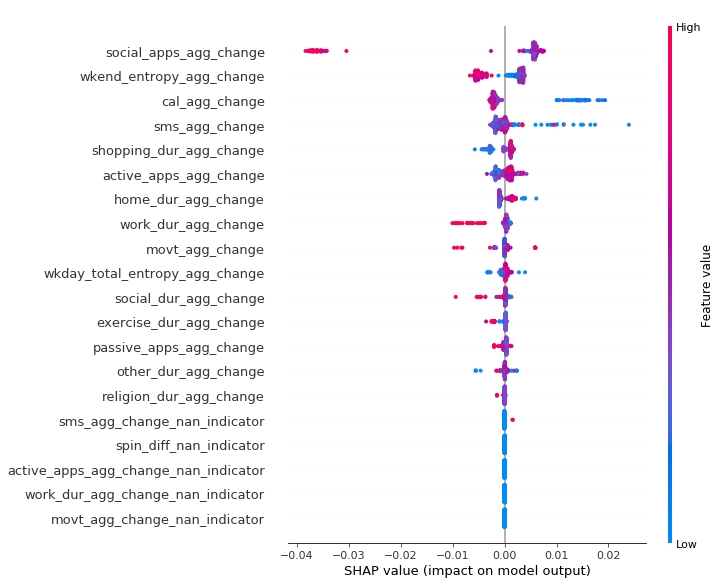

In [635]:
shap.summary_plot(shap_values[1], X_test_gad.drop('pid', axis='columns'))

### SHAP for increases (+1)
- higher values means the model is more likely to predict 1

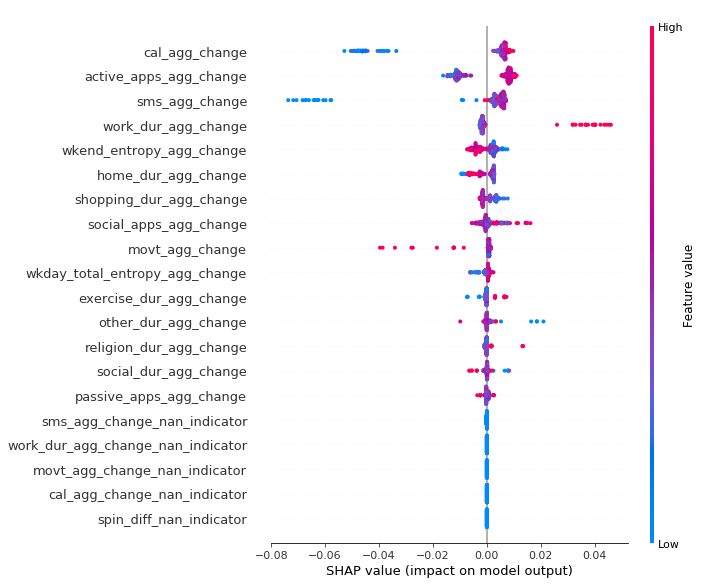

In [636]:
shap.summary_plot(shap_values[2], X_test_gad.drop('pid', axis='columns'))

# Predicting GAD Changes (reversed)

In [637]:
def class_labels(x):
    if x > 0: return 1
    if x < 0: return -1
    return 0

y_rev_train_gad_class = y_rev_train_gad.apply(class_labels)
y_rev_test_gad_class = y_rev_test_gad.apply(class_labels)

In [638]:
y_rev_train_gad_class.value_counts()

 1    313
-1    309
 0    154
Name: gad_diff, dtype: int64

In [639]:
rev_gad_groups = X_rev_train_gad.pop('pid')
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X_rev_train_gad, y_rev_train_gad, rev_gad_groups)

5

In [640]:
rf = RandomForestClassifier()

random_search_params = dict(
    bootstrap=[True, False],
    max_depth=[None] + [x for x in range(1, 11, 1)],
    max_features=['auto', 'sqrt'],
    min_samples_leaf=[x for x in range(1, 5)],
    min_samples_split=[x for x in range(2, 11, 2)],
    n_estimators=[x for x in range(100, 1001, 100)]
)

f1_scorer = make_scorer(f1_score, average='micro')

rev_gad_clf = RandomizedSearchCV(rf, 
                             random_search_params, 
                             cv=group_kfold.split(X_rev_train_gad, y_rev_train_gad_class, rev_gad_groups),
                             n_iter=100,
                             random_state=2,
                             verbose=True, 
                             n_jobs=10,
                             scoring=f1_scorer)
rev_gad_clf_random_search = rev_gad_clf.fit(X_rev_train_gad, y_rev_train_gad_class)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   19.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   40.7s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   49.2s finished


In [641]:
rev_gad_clf_random_search.best_score_

0.4213917525773196

In [642]:
rev_gad_clf_random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True}

In [643]:
from sklearn.metrics import accuracy_score, f1_score
rev_train_preds_gad_class = rev_gad_clf_random_search.predict(X_rev_train_gad)
print(accuracy_score(y_true=y_rev_train_gad_class, y_pred=rev_train_preds_gad_class))
print(f1_score(y_true=y_rev_train_gad_class, y_pred=rev_train_preds_gad_class, average='weighted'))

0.7680412371134021
0.7109938277854422


In [644]:
y_rev_train_gad_class.shape

(776,)

In [645]:
best_rev_gad_clf = rev_gad_clf_random_search.best_estimator_
joblib.dump(best_rev_gad_clf, "models/best_rev_gad_clf.pkl")

['models/best_rev_gad_clf.pkl']

In [646]:
maj_pred = [-1] * y_rev_train_gad_class.shape[0]
print("majority baseline rev_train acc: {}".format(accuracy_score(y_true=y_rev_train_gad_class, y_pred=maj_pred)))
print("majority baseline rev_train weighted F1: {}".format(f1_score(y_true=y_rev_train_gad_class, y_pred=maj_pred, average='weighted')))

majority baseline rev_train acc: 0.39819587628865977
majority baseline rev_train weighted F1: 0.22680649912109843


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [647]:
rev_test_preds_gad_class = best_rev_gad_clf.predict(X_rev_test_gad.drop('pid', axis='columns'))
print("RF rev_test acc: {}".format(accuracy_score(y_true=y_rev_test_gad_class, y_pred=rev_test_preds_gad_class)))
print("RF rev_test weighted F1: {}".format(f1_score(y_true=y_rev_test_gad_class, y_pred=rev_test_preds_gad_class, average='weighted')))
#print(roc_auc_score(y_true=y_rev_test_gad_class, y_score=rev_test_scores_gad_class, average='weighted', multi_class='ovr'))

RF rev_test acc: 0.4163424124513619
RF rev_test weighted F1: 0.3676808258739375


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [648]:
maj_pred = [-1] * y_rev_test_gad_class.shape[0]
print("majority baseline rev_test acc: {}".format(accuracy_score(y_true=y_rev_test_gad_class, y_pred=maj_pred)))
print("majority baseline rev_test weighted f1: {}".format(f1_score(y_true=y_rev_test_gad_class, y_pred=maj_pred, average='weighted')))

majority baseline rev_test acc: 0.4163424124513619
majority baseline rev_test weighted f1: 0.24477273699063584


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SHAP Feature Importance

In [649]:
explainer = shap.TreeExplainer(best_rev_gad_clf)

### Test Data

In [650]:
shap_values = explainer.shap_values(X_test_gad.drop('pid', axis='columns'))

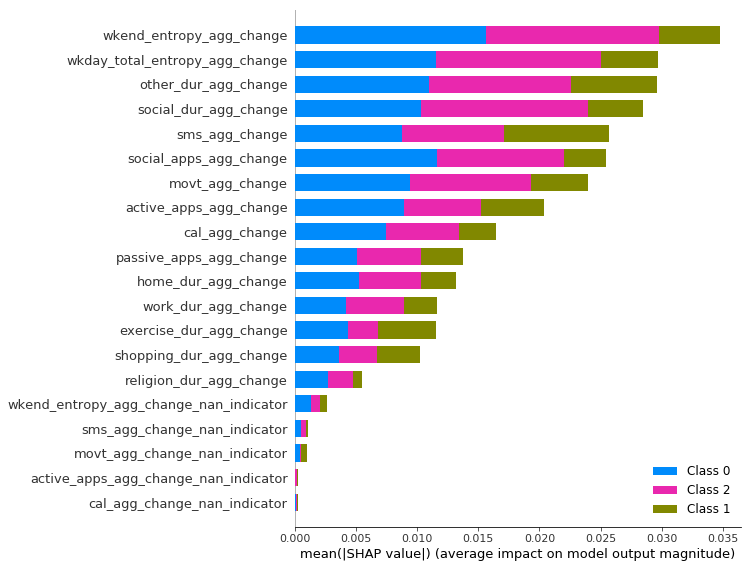

In [651]:
shap.summary_plot(shap_values, X_test_gad.drop('pid', axis='columns'))

# Predicting SPIN Changes

In [652]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.externals import joblib

In [653]:
spin_groups = X_train_spin.pop('pid')
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X_train_spin, y_train_spin, spin_groups)

5

## Classification

In [654]:
scaler = StandardScaler()
#X_train_spin = scaler.fit_transform(X_train_spin)
#X_test_spin_scale = scaler.fit_transform(X_test_spin.drop('pid', axis='columns'))

In [655]:
search_params

{'bootstrap': [True, False],
 'criterion': ['mse', 'mae'],
 'max_depth': [None, 10, 20, 30, 40, 50],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

### Random search to find reasonable ranges

In [656]:
def class_labels(x):
    if x > 0: return 1
    if x < 0: return -1
    return 0

y_train_spin_class = y_train_spin.apply(class_labels)
y_test_spin_class = y_test_spin.apply(class_labels)

In [657]:
y_train_spin_class.value_counts()

-1    346
 1    344
 0     86
Name: spin_diff, dtype: int64

In [658]:
rf = RandomForestClassifier()

random_search_params = dict(
    bootstrap=[True, False],
    max_depth=[None] + [x for x in range(1, 11, 1)],
    max_features=['auto', 'sqrt'],
    min_samples_leaf=[x for x in range(1, 5)],
    min_samples_split=[x for x in range(2, 11, 2)],
    n_estimators=[x for x in range(100, 1001, 100)]
)

f1_scorer = make_scorer(f1_score, average='micro')

spin_clf = RandomizedSearchCV(rf, 
                             random_search_params, 
                             cv=group_kfold.split(X_train_spin, y_train_spin_class, spin_groups),
                             n_iter=100,
                             random_state=2,
                             verbose=True, 
                             n_jobs=10,
                             scoring=f1_scorer)
spin_clf_random_search = spin_clf.fit(X_train_spin, y_train_spin_class)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   19.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   40.3s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   48.4s finished


In [659]:
spin_clf_random_search.best_score_

0.5012886597938144

In [660]:
spin_clf_random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 9,
 'bootstrap': True}

In [661]:
from sklearn.metrics import accuracy_score, f1_score
train_preds_spin_class = spin_clf_random_search.predict(X_train_spin)
print(accuracy_score(y_true=y_train_spin_class, y_pred=train_preds_spin_class))
print(f1_score(y_true=y_train_spin_class, y_pred=train_preds_spin_class, average='weighted'))

0.8891752577319587
0.8625388210575811


In [662]:
y_train_spin_class.shape

(776,)

In [663]:
best_spin_clf = spin_clf_random_search.best_estimator_
joblib.dump(best_spin_clf, "models/best_spin_clf.pkl")

['models/best_spin_clf.pkl']

In [664]:
maj_pred = [-1] * y_train_spin_class.shape[0]
print("majority baseline train acc: {}".format(accuracy_score(y_true=y_train_spin_class, y_pred=maj_pred)))
print("majority baseline train weighted F1: {}".format(f1_score(y_true=y_train_spin_class, y_pred=maj_pred, average='weighted')))

majority baseline train acc: 0.44587628865979384
majority baseline train weighted F1: 0.27499678409320616


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [665]:
test_preds_spin_class = best_spin_clf.predict(X_test_spin.drop('pid', axis='columns'))
print("RF test acc: {}".format(accuracy_score(y_true=y_test_spin_class, y_pred=test_preds_spin_class)))
print("RF test weighted F1: {}".format(f1_score(y_true=y_test_spin_class, y_pred=test_preds_spin_class, average='weighted')))
#print(roc_auc_score(y_true=y_test_spin_class, y_score=test_scores_spin_class, average='weighted', multi_class='ovr'))

RF test acc: 0.4708171206225681
RF test weighted F1: 0.4418715004270665


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [666]:
maj_pred = [-1] * y_test_spin_class.shape[0]
print("majority baseline test acc: {}".format(accuracy_score(y_true=y_test_spin_class, y_pred=maj_pred)))
print("majority baseline test weighted f1: {}".format(f1_score(y_true=y_test_spin_class, y_pred=maj_pred, average='weighted')))

majority baseline test acc: 0.42023346303501946
majority baseline test weighted f1: 0.24868610415223072


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SHAP Feature Importance

In [667]:
explainer = shap.TreeExplainer(best_spin_clf)

### Test Data

In [668]:
shap_values = explainer.shap_values(X_test_spin.drop('pid', axis='columns'))

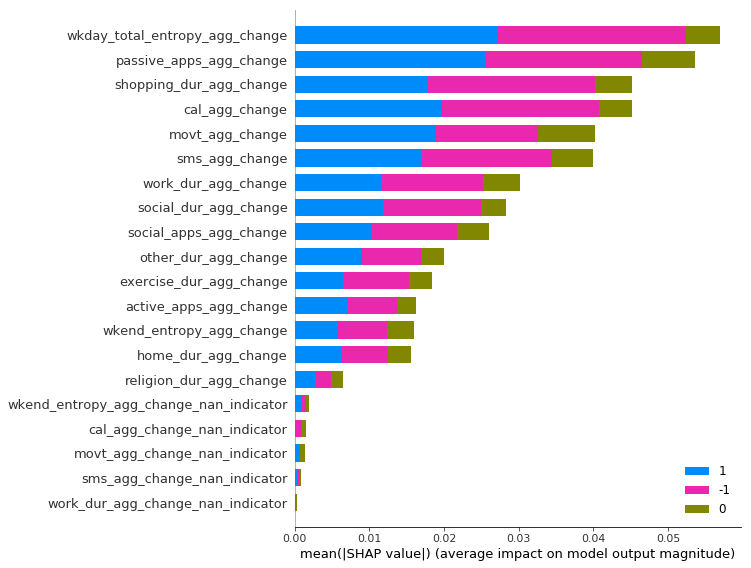

In [669]:
shap.summary_plot(shap_values, X_test_spin.drop('pid', axis='columns'), class_names=[-1,0,1])

### SHAP for decreases (-1)
- higher values means the model is more likely to predict -1

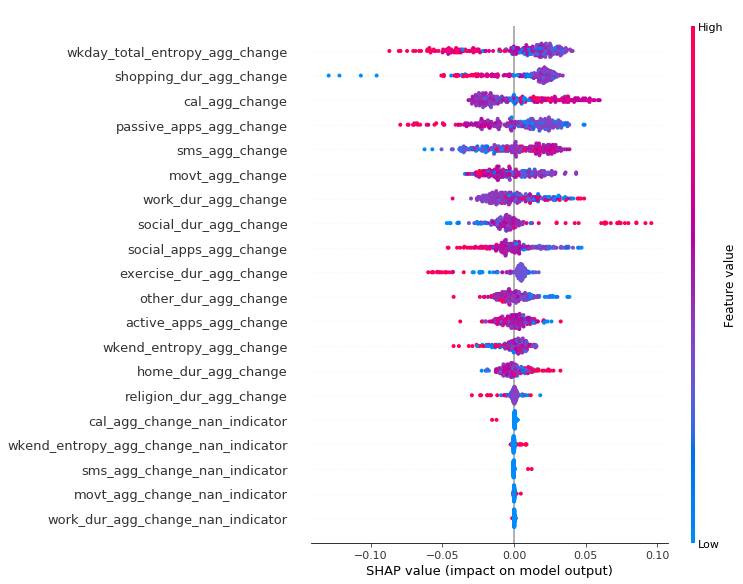

In [670]:
shap.summary_plot(shap_values[0], X_test_spin.drop('pid', axis='columns'))

### SHAP for no change (0)
- higher values means the model is more likely to predict 0

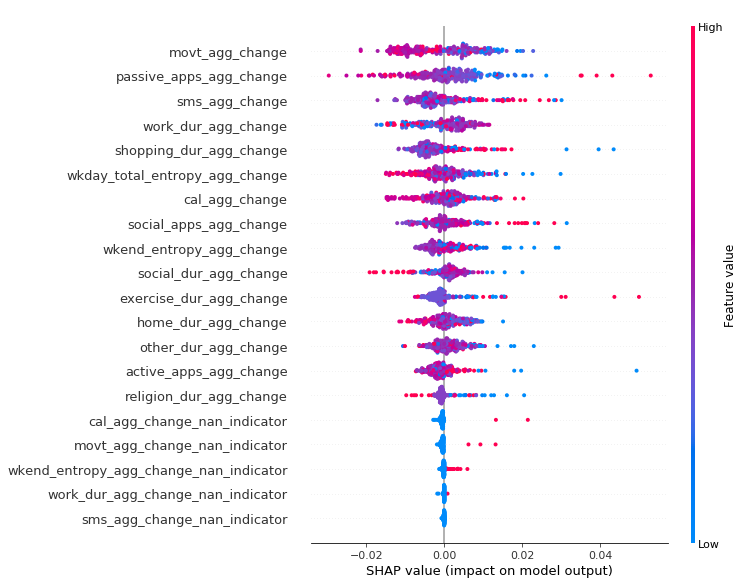

In [671]:
shap.summary_plot(shap_values[1], X_test_spin.drop('pid', axis='columns'))

### SHAP for increases (+1)
- higher values means the model is more likely to predict 1

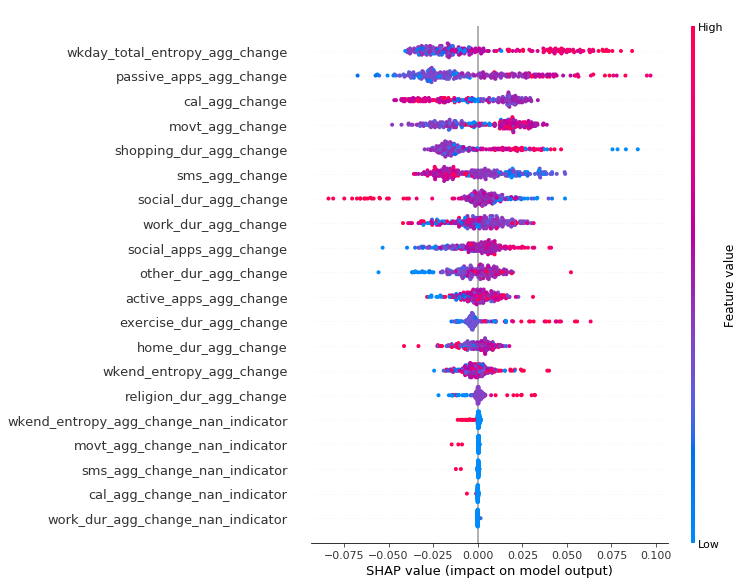

In [672]:
shap.summary_plot(shap_values[2], X_test_spin.drop('pid', axis='columns'))

# Predicting SPIN Changes (reversed)

In [673]:
def class_labels(x):
    if x > 0: return 1
    if x < 0: return -1
    return 0

y_rev_train_spin_class = y_rev_train_spin.apply(class_labels)
y_rev_test_spin_class = y_rev_test_spin.apply(class_labels)

In [674]:
y_rev_train_spin_class.value_counts()

-1    346
 1    344
 0     86
Name: spin_diff, dtype: int64

In [675]:
rev_spin_groups = X_rev_train_spin.pop('pid')
group_kfold = GroupKFold(n_splits = 5)
group_kfold.get_n_splits(X_rev_train_spin, y_rev_train_spin, rev_spin_groups)

5

In [676]:
rf = RandomForestClassifier()

random_search_params = dict(
    bootstrap=[True, False],
    max_depth=[None] + [x for x in range(1, 11, 1)],
    max_features=['auto', 'sqrt'],
    min_samples_leaf=[x for x in range(1, 5)],
    min_samples_split=[x for x in range(2, 11, 2)],
    n_estimators=[x for x in range(100, 1001, 100)]
)

f1_scorer = make_scorer(f1_score, average='micro')

rev_spin_clf = RandomizedSearchCV(rf, 
                             random_search_params, 
                             cv=group_kfold.split(X_rev_train_spin, y_rev_train_spin_class, rev_spin_groups),
                             n_iter=100,
                             random_state=2,
                             verbose=True, 
                             n_jobs=10,
                             scoring=f1_scorer)
rev_spin_clf_random_search = rev_spin_clf.fit(X_rev_train_spin, y_rev_train_spin_class)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   19.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   40.4s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   48.7s finished


In [677]:
rev_spin_clf_random_search.best_score_

0.5128865979381443

In [678]:
rev_spin_clf_random_search.best_params_

{'n_estimators': 700,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 9,
 'bootstrap': True}

In [679]:
from sklearn.metrics import accuracy_score, f1_score
rev_train_preds_spin_class = rev_spin_clf_random_search.predict(X_rev_train_spin)
print(accuracy_score(y_true=y_rev_train_spin_class, y_pred=rev_train_preds_spin_class))
print(f1_score(y_true=y_rev_train_spin_class, y_pred=rev_train_preds_spin_class, average='weighted'))

0.8556701030927835
0.8073573967057618


In [680]:
y_rev_train_spin_class.shape

(776,)

In [681]:
best_rev_spin_clf = rev_spin_clf_random_search.best_estimator_
joblib.dump(best_rev_spin_clf, "models/best_rev_spin_clf.pkl")

['models/best_rev_spin_clf.pkl']

In [682]:
maj_pred = [-1] * y_rev_train_spin_class.shape[0]
print("majority baseline rev_train acc: {}".format(accuracy_score(y_true=y_rev_train_spin_class, y_pred=maj_pred)))
print("majority baseline rev_train weighted F1: {}".format(f1_score(y_true=y_rev_train_spin_class, y_pred=maj_pred, average='weighted')))

majority baseline rev_train acc: 0.44587628865979384
majority baseline rev_train weighted F1: 0.27499678409320616


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [683]:
rev_test_preds_spin_class = best_rev_spin_clf.predict(X_rev_test_spin.drop('pid', axis='columns'))
print("RF rev_test acc: {}".format(accuracy_score(y_true=y_rev_test_spin_class, y_pred=rev_test_preds_spin_class)))
print("RF rev_test weighted F1: {}".format(f1_score(y_true=y_rev_test_spin_class, y_pred=rev_test_preds_spin_class, average='weighted')))
#print(roc_auc_score(y_true=y_rev_test_spin_class, y_score=rev_test_scores_spin_class, average='weighted', multi_class='ovr'))

RF rev_test acc: 0.43190661478599224
RF rev_test weighted F1: 0.4052190780094008


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [684]:
maj_pred = [-1] * y_rev_test_spin_class.shape[0]
print("majority baseline rev_test acc: {}".format(accuracy_score(y_true=y_rev_test_spin_class, y_pred=maj_pred)))
print("majority baseline rev_test weighted f1: {}".format(f1_score(y_true=y_rev_test_spin_class, y_pred=maj_pred, average='weighted')))

majority baseline rev_test acc: 0.42023346303501946
majority baseline rev_test weighted f1: 0.24868610415223072


/home/tliu/.conda/envs/shap/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SHAP Feature Importance

In [685]:
explainer = shap.TreeExplainer(best_rev_spin_clf)

### Test Data

In [686]:
shap_values = explainer.shap_values(X_test_spin.drop('pid', axis='columns'))

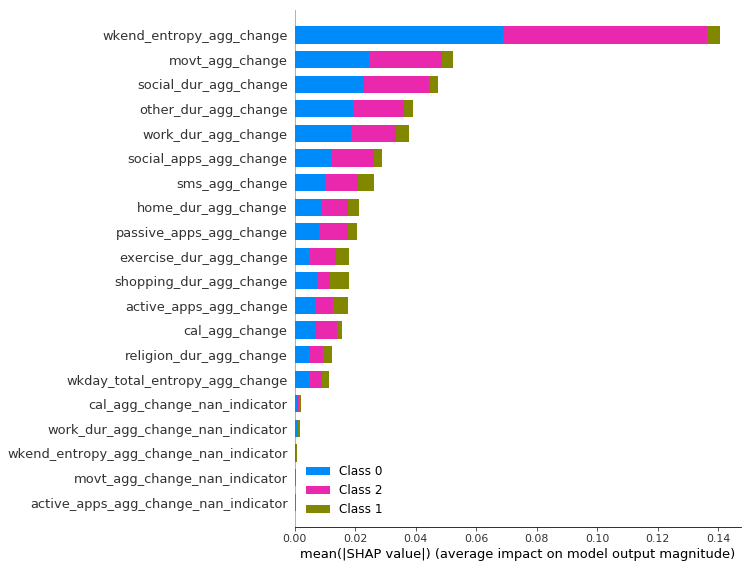

In [687]:
shap.summary_plot(shap_values, X_test_spin.drop('pid', axis='columns'))